# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
import nltk
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [3]:
# add any additional libaries you need here
import sys
import warnings
import matplotlib.pyplot as plt


sys.version #3.9.2 Python
warnings.filterwarnings('ignore')


In [4]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [5]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [6]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [7]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<AxesSubplot:xlabel='category'>

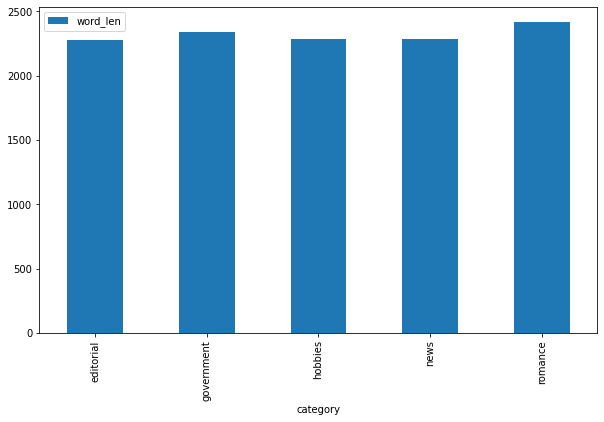

In [9]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [10]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4941)

In [11]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: Both the `count_text_vectors` and `tfidf_text_vectors` are document-term matrices that hold the stored elements. The count vectorizer uses a bag-of-words approach that counts the number of times a word appears in the document. The Tfidf vectorizer is similar to the count vectorizer where it also counts the amount of times a word appears in the document, but also scores the vectors in the importance of the term for the document.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [12]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [13]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [24]:
# Your code here

topic_to_category = defaultdict(list)

for idx, row in enumerate(W_text_matrix):
    topic = np.where(row == np.amax(row))[0]
    category = df["category"].iloc[idx]
    topic_to_category[topic[0]].append(category)

# Now look into the most common categories for comparison.

for topic, categories in topic_to_category.items():
    print(f"Topic {topic} has {len(categories)} documents.")
    print(Counter(categories).most_common(5))

Topic 2 has 65 documents.
[('government', 26), ('hobbies', 26), ('news', 11), ('editorial', 2)]
Topic 0 has 32 documents.
[('editorial', 20), ('news', 8), ('government', 4)]
Topic 1 has 41 documents.
[('romance', 29), ('hobbies', 8), ('editorial', 4)]
Topic 4 has 10 documents.
[('news', 8), ('editorial', 1), ('hobbies', 1)]
Topic 3 has 18 documents.
[('news', 17), ('hobbies', 1)]


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The NMF model compared to the original Brown categories seem to not have the best overlap as the NMF has more unique terms while the original Brown categories lists more of the top words that don't relate to the NMF. NMF model shows a break down is more specific; however both don't really do a great job of explaining the categories well.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [21]:
# Your code here
svd_text_model = TruncatedSVD(n_components = 5, random_state=314)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The LSA model compares more in line with the NMF model than the original Brown categories. The LSA model shows more of the terms within each topic similar to NMF especially in the fourth topic where both show clear similarities of baseball terminology.

In [22]:
# call display_topics on your model
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


In [25]:
topic_to_category = defaultdict(list)

for idx, row in enumerate(W_svd_text_matrix):
    topic = np.where(row == np.amax(row))[0]
    category = df["category"].iloc[idx]
    topic_to_category[topic[0]].append(category)

# Now look into the most common categories for comparison.

for topic, categories in topic_to_category.items():
    print(f"Topic {topic} has {len(categories)} documents.")
    print(Counter(categories).most_common(5))

Topic 0 has 148 documents.
[('hobbies', 36), ('news', 34), ('government', 30), ('editorial', 27), ('romance', 21)]
Topic 4 has 7 documents.
[('news', 7)]
Topic 3 has 3 documents.
[('news', 3)]
Topic 1 has 8 documents.
[('romance', 8)]


Q: What is your interpretation of the display topics output? 

A: This shows that topic 0 has the most amount of information containing a variety of categories while the remaining topics don't have as many documents or categories within each display. Topic 0 has the largest spread that is fairly even across categories.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [17]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_text_model.components_

In [18]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names())


Topic 00
  clay (0.54)
  game (0.47)
  place (0.45)
  cut (0.45)
  home (0.44)

Topic 01
  pool (0.77)
  use (0.71)
  national (0.70)
  area (0.57)
  good (0.56)

Topic 02
  million (0.60)
  military (0.57)
  sales (0.54)
  aircraft (0.54)
  equipment (0.50)

Topic 03
  feed (3.04)
  said (1.47)
  head (1.08)
  meeting (0.94)
  daily (0.91)

Topic 04
  said (1.83)
  sam (0.67)
  eyes (0.63)
  thought (0.63)
  little (0.58)

Topic 05
  mrs (1.05)
  said (0.88)
  old (0.67)
  mr (0.56)
  man (0.56)

Topic 06
  said (2.73)
  board (0.85)
  000 (0.66)
  court (0.56)
  county (0.55)

Topic 07
  state (1.08)
  medical (0.75)
  shelter (0.68)
  program (0.53)
  service (0.53)

Topic 08
  state (0.85)
  united (0.78)
  states (0.72)
  government (0.70)
  president (0.67)

Topic 09
  fiscal (1.00)
  property (0.86)
  island (0.69)
  tax (0.69)
  state (0.61)


In [26]:
topic_to_category = defaultdict(list)

for idx, row in enumerate(W_lda_para_matrix):
    topic = np.where(row == np.amax(row))[0]
    category = df["category"].iloc[idx]
    topic_to_category[topic[0]].append(category)

# Now look into the most common categories for comparison.

for topic, categories in topic_to_category.items():
    print(f"Topic {topic} has {len(categories)} documents.")
    print(Counter(categories).most_common(5))

Topic 8 has 40 documents.
[('editorial', 15), ('news', 12), ('government', 11), ('romance', 1), ('hobbies', 1)]
Topic 5 has 45 documents.
[('romance', 20), ('news', 11), ('hobbies', 8), ('editorial', 5), ('government', 1)]
Topic 1 has 9 documents.
[('government', 3), ('hobbies', 3), ('editorial', 2), ('news', 1)]
Topic 2 has 13 documents.
[('editorial', 5), ('government', 3), ('news', 3), ('hobbies', 2)]
Topic 9 has 8 documents.
[('government', 4), ('hobbies', 4)]
Topic 7 has 11 documents.
[('government', 5), ('hobbies', 5), ('news', 1)]
Topic 4 has 8 documents.
[('romance', 6), ('government', 2)]
Topic 6 has 11 documents.
[('news', 9), ('government', 1), ('hobbies', 1)]
Topic 0 has 18 documents.
[('hobbies', 11), ('news', 7)]
Topic 3 has 3 documents.
[('romance', 2), ('hobbies', 1)]


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The LDA model has more displayed topics than the other models with a more defining terminology provided for each topic. The terms shown provide more detail than the other models that don't really have valuable insight such as miss, ll, etc., while the LDA model terms show terminology relating more towards the categories.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: This model compares closer with the original Brown categories showing more of a spread that has more of an overlap. For this model, there are significantly more topics with a larger spread of categories for each topic. Topic 8 has the largest amount of categories with 40 documents while the topic 5 has 45 documents with a more concentrated category of romance than the otehr categories within that topic. 

In [19]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [20]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: For the scatterplot, topic 1, 4, and 7 have no overlap in terms with 7 appearing to be the farthest away from all other topics. Topics 2, 3, 8, 9, and 10 all seem to have a closer relationship with overlapping. Topic 9 shows 25.4% of the tokens in the salient terms graph with the overlapping topics sharing terms in common that cross between different focus areas of the government category. Topic 5 and 6 overlap in the scatterplot with the salient terms graph showing that terms such as little, said, mrs and mr being more frequent across these topics.
